In [1]:
import os
os.chdir('/Users/marcs')

In [22]:
import matplotlib.pyplot as plt
from pickle_loader import pickle_loader
import datetime as dt
import pandas as pd
from random import seed
from random import randint
import numpy as np
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [3]:
technical_data = pickle_loader('/Users/marcs/OneDrive/Documents/stock_analysis2/technical_us.pickle')

In [4]:
def tech_clean(dataset):
    clean_dataset = dataset.copy()
    tickers = list(technical_data.keys())
    removed_tickers = []
    
    for ticker in tickers:
        if len(dataset[ticker]) == 0: # Remove tickers that are empty 
            clean_dataset.pop(ticker, None)
            removed_tickers.append(ticker)
        else: # Remove tickers that don't contain the full dataset 
            first_time = dataset[ticker].index.to_pydatetime()[0].strftime('%d-%m-%Y')
            last_time = dataset[ticker].index.to_pydatetime()[-1].strftime('%d-%m-%Y')
            if first_time != '30-09-2021' or last_time != '29-09-2023':
                clean_dataset.pop(ticker, None)
                removed_tickers.append(ticker)
    
    return clean_dataset, removed_tickers 

In [5]:
clean_tech_data, removed_tickers = tech_clean(technical_data)

The close price is the price that is being modeled/pricted

The start of the train dataset is '2021-09-30 00:00:00-0400'.

The end of the train set is '2022-09-27 00:00:00-0400' .

In [11]:
tickers = clean_tech_data.keys()
train_set = [clean_tech_data[ticker].loc['2021-09-30 00:00:00-0400':'2022-09-27 00:00:00-0400']['Close'].to_numpy() for ticker in tickers]

The date we are trying to pridict is 2022-12-27

In [14]:
test_set = [clean_tech_data[ticker].loc['2022-12-27 00:00:00-0500']['Close'] for ticker in tickers]

In [18]:
def get_smoothing_data(len_smoothing_period, train_set , num_day_train_set):
    smoothing_data = []
    
    for stock_data in train_set:
        len_stock_set = stock_data.size
        factor_missing_days = len_stock_set / num_day_train_set # factor which captures the ratio of missing days in the total number of days in the train set
        adjusted_smoothing_period = int(np.round(len_smoothing_period * factor_missing_days)) # smoothing period ajusted for the missing days 
        remainder = len_stock_set % adjusted_smoothing_period
        len_start_period = adjusted_smoothing_period + remainder
        
        first_value = np.mean(stock_data[:len_start_period])
        other_values = np.mean(stock_data[len_start_period:].reshape(-1, adjusted_smoothing_period), axis = 1)
        
        smoothing_data.append(np.insert(other_values, 0, first_value))
        
    return smoothing_data

In [49]:
smoothing_periods = [length for length in range(1,100)]

In [50]:
def fit_Armia(dataset):
    trained_models = []
    for stock_data in dataset:
        trained_models.append(\
        pm.auto_arima(stock_data, d=1, seasonal=False, stepwise=True,\
            suppress_warnings=True, error_action="ignore", max_p=6,\
            max_order=None, trace=False))
    return trained_models    

In [51]:
# Find the number of periods to forcast the stock price between 2022-09-27 and 2022-12-27 
from datetime import date

def num_forcast_periods(start_date, end_date, period):
    delta = end_date - start_date 
    return int(np.round(delta.days/period))

In [52]:
def forecast_n_steps(model, n):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

def forcast_model_lst(model_lst, n):
    all_predictions = []
    for model in model_lst:
        all_predictions.append(forecast_n_steps(model, n))
    return all_predictions

In [53]:
smoothing_periods_predictions = {}

for period in smoothing_periods:
    smoothing_data = get_smoothing_data(period, train_set, 365) # Dataset creation 
    print('-'*18)
    trained_models = fit_Armia(smoothing_data) # Model Fitting 
    
    num_periods = num_forcast_periods(date(2022, 9, 27), date(2022, 12, 27), period)
    print('The number of smoothing periods:', num_periods)
    smoothing_periods_predictions[str(period)] = forcast_model_lst(trained_models, num_periods)
    
    print((period/smoothing_periods[-1])*100, '% Complete')

------------------
The number of smoothing periods: 91
1.0101010101010102 % Complete
------------------
The number of smoothing periods: 46
2.0202020202020203 % Complete
------------------
The number of smoothing periods: 30
3.0303030303030303 % Complete
------------------
The number of smoothing periods: 23
4.040404040404041 % Complete
------------------
The number of smoothing periods: 18
5.05050505050505 % Complete
------------------
The number of smoothing periods: 15
6.0606060606060606 % Complete
------------------
The number of smoothing periods: 13
7.07070707070707 % Complete
------------------
The number of smoothing periods: 11
8.080808080808081 % Complete
------------------
The number of smoothing periods: 10
9.090909090909092 % Complete
------------------
The number of smoothing periods: 9
10.1010101010101 % Complete
------------------
The number of smoothing periods: 8
11.11111111111111 % Complete
------------------
The number of smoothing periods: 8
12.121212121212121 % Co

In [54]:
smoothing_periods_predictions['1'][0]

(106.20890979690245, [102.00330197535892, 110.41451761844597])

In [55]:
y_pred = {k:[pred[0] for pred in k_pred] for k, k_pred in smoothing_periods_predictions.items()}

MSE = {}
SMAPE = {}
for smoothing, predictions in y_pred.items():
    MSE[smoothing] = mean_squared_error(test_set, predictions)
    SMAPE[smoothing] = smape(test_set, predictions)
    
print(MSE)
print(SMAPE)

{'1': 2694.8065900291112, '2': 2694.8065900291112, '3': 2646.3553678241337, '4': 2585.0576584047967, '5': 2585.0576584047967, '6': 2546.125765188195, '7': 2336.810694986769, '8': 2336.810694986769, '9': 2273.6430769049484, '10': 2159.234527521327, '11': 2094.5090301075547, '12': 2094.5090301075547, '13': 2087.152276430603, '14': 2154.544888422312, '15': 2154.544888422312, '16': 1994.3624106017605, '17': 1900.2001868688733, '18': 1900.2001868688733, '19': 1860.2292913346212, '20': 1787.5084845332315, '21': 1787.5084845332315, '22': 1760.2700194884171, '23': 2033.2132784461128, '24': 2033.2132784461128, '25': 2098.720961781516, '26': 1790.2731977397145, '27': 1790.2731977397145, '28': 1796.2761601365942, '29': 1770.4552608755519, '30': 2008.594224156762, '31': 2008.594224156762, '32': 2069.5140358401823, '33': 1700.0455060216734, '34': 1700.0455060216734, '35': 1664.5463168624606, '36': 1785.6705048617791, '37': 1785.6705048617791, '38': 1550.2744684205659, '39': 1543.2701807196531, '40'

The minumum SMAPE is: 10.9868211329322
The length of smoothing period for the min SMAPE is: 46


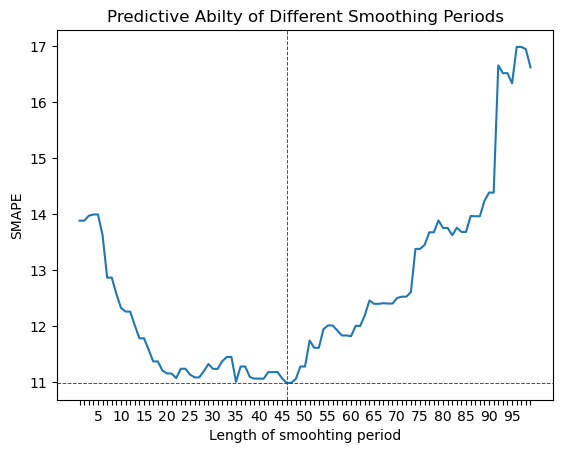

In [76]:
SMAPE_array = np.array(list(SMAPE.values()))
SMAPE_min = np.min(SMAPE_array)
print('The minumum SMAPE is:', SMAPE_min)
length_min = list(SMAPE.keys())[np.argmin(SMAPE_array)]
print('The length of smoothing period for the min SMAPE is:', length_min)
lengths = [length if int(length) % 5 == 0  else '' for length in SMAPE.keys()]

plt.plot(SMAPE.keys(), SMAPE.values())
plt.xticks(range(0,99),lengths)
plt.axhline(y=SMAPE_min, color='r', linestyle='--', linewidth=0.7)
plt.axvline(x=length_min, color='r', linestyle='--', linewidth=0.7)
plt.ylabel('SMAPE')
plt.xlabel('Length of smoohting period')
plt.title('Predictive Abilty of Different Smoothing Periods')
plt.show()

In [81]:
y_conf_width = {k:np.mean(np.array([pred[1][1] - pred[1][0] for pred in k_pred])) for k, k_pred in smoothing_periods_predictions.items()}
y_conf_width

{'1': 14.25150746454177,
 '2': 14.25150746454177,
 '3': 17.194662880622772,
 '4': 19.894002092004182,
 '5': 19.894002092004182,
 '6': 22.744819685071626,
 '7': 25.915916662889316,
 '8': 25.915916662889316,
 '9': 27.292194521770565,
 '10': 30.885237673783127,
 '11': 31.126171922883405,
 '12': 31.126171922883405,
 '13': 32.91725419386258,
 '14': 32.38870505267343,
 '15': 32.38870505267343,
 '16': 37.32665968681541,
 '17': 38.59813196564497,
 '18': 38.59813196564497,
 '19': 37.81190462854208,
 '20': 40.04944214686306,
 '21': 40.04944214686306,
 '22': 43.45010597014315,
 '23': 41.304500710708204,
 '24': 41.304500710708204,
 '25': 41.50807413411897,
 '26': 44.81592426956623,
 '27': 44.81592426956623,
 '28': 44.62186828594974,
 '29': 45.04570323986235,
 '30': 45.368636189241954,
 '31': 45.368636189241954,
 '32': 47.37027439867844,
 '33': 46.67163080141334,
 '34': 46.67163080141334,
 '35': 47.31256717969452,
 '36': 49.71234695841046,
 '37': 49.71234695841046,
 '38': 50.30362081890563,
 '39': 

The minumum SMAPE is: 14.25150746454177
The length of smoothing period for the min SMAPE is: 1


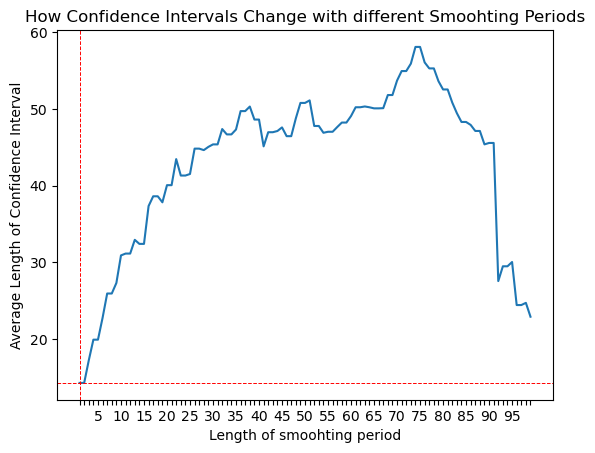

In [83]:
yconf_array = np.array(list(y_conf_width.values()))
yconf_min = np.min(yconf_array)
print('The minumum SMAPE is:', yconf_min)
length_min = list(y_conf_width.keys())[np.argmin(yconf_array)]
print('The length of smoothing period for the min SMAPE is:', length_min)
lengths = [length if int(length) % 5 == 0  else '' for length in y_conf_width.keys()]

plt.plot(y_conf_width.keys(), y_conf_width.values())
plt.xticks(range(0,99),lengths)
plt.axhline(y=yconf_min, color='r', linestyle='--', linewidth=0.7)
plt.axvline(x=length_min, color='r', linestyle='--', linewidth=0.7)
plt.ylabel('Average Length of Confidence Interval')
plt.xlabel('Length of smoohting period')
plt.title('How Confidence Intervals Change with different Smoohting Periods')
plt.show()